# Machine learning (Metodo No supervisado)

# ¿Podemos detectar patrones entre consumidores específicos para identificar posibles fraudes?

## Metas (2 min)

Al final de este caso, estará familiarizado con $k$-means como algoritmo de agrupamiento. Específicamente, aprenderá el algoritmo detrás de $k$, de tal manera que pueda intuir mejor cuándo funciona bien y cuándo no.

Durante el estudio de caso, realizará EDA en su conjunto de datos y observará un agrupamiento natural en los datos. A continuación, se le presentará el $k$-means como una forma de automatizar este proceso. Luego, continuará implementándolo y ajustará el algoritmo para validar sus hallazgos. Será capaz de diseccionar algoritmos y ajustar sus datos al algoritmo.

## Introduccion (5 min)

**Contexto comercial.** Trabaja para el equipo de fraude en una gran compañía de seguros que se ocupa de emitir pólizas de seguro para varios tipos de reclamos tanto para individuos como para empresas. Las pólizas que se emiten se controlan y cualquier reclamo presentado se examina y evalúa para determinar la legitimidad y la aprobación final para el pago por parte de la compañía de seguros. Sin embargo, muchas personas intentan aprovecharse, presentando reclamos con falsos pretextos para obtener ingresos adicionales. Es función del equipo de fraude determinar qué reclamos presentados deben aprobarse y cuáles deben rechazarse.

**Problema comercial.** Su tarea es responder la siguiente pregunta: **¿Existen patrones particulares en los grupos de reclamos presentados que puedan ser indicativos de fraude?**

**Contexto analítico.** El equipo de contabilidad le ha proporcionado datos sobre todas las reclamaciones recientes realizadas por 1000 personas. A diferencia de los casos anteriores, los datos aquí no estarán etiquetados; es decir, no hay una variable que nos diga cuáles de estas afirmaciones son fraudulentas o no. En su lugar, debemos utilizar **modelos de agrupamiento** para abordar este problema de **aprendizaje no supervisado**.

El caso se estructura de la siguiente manera, vamos a:
1. realizar análisis de datos exploratorios para investigar visualmente la estructura de los datos
2. Utilizar estas observaciones para guiar nuestra metodología de agrupamiento y ajustar los modelos adecuados.
3. discutir las ventajas y limitaciones de los métodos de agrupamiento típicos; y finalmente
4. segmentar y generar conclusiones sobre grupos específicos

## Exploracion de datos (15 min)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn # Paquete base de ML

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

%matplotlib inline

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en dr
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


Comencemos importando los datos disponibles y mirando las primeras filas:

In [2]:
# Importar los datos
df_data = pd.read_excel('insurance_data_1000.xlsx')
df_data.head(5)

,case_id,income,age,sex,approval,fraud,claims
0,59982,35750.95,42,M,Approved,Under Review,9518.95
1,87249,24078.27,19,M,Denied,No,19354.23
2,50406,39241.52,37,M,Denied,Fraud,13056.04
3,59391,33248.31,26,M,Approved,No,19238.37
4,96622,38649.96,54,M,Approved,No,14427.42


In [10]:
# Estamos interesados en ciertas columnas de interes
df = df_data[['case_id', 'income', 'age', 'claims','sex']]
df.head(5)

,case_id,income,age,claims,sex
0,59982,35750.95,42,9518.95,M
1,87249,24078.27,19,19354.23,M
2,50406,39241.52,37,13056.04,M
3,59391,33248.31,26,19238.37,M
4,96622,38649.96,54,14427.42,M


A continuación, echemos un vistazo al conjunto de reclamos bajo revisión y cómo se distribuyen:

In [4]:
df_frauds = df_data[df_data['fraud'] == 'Under Review']
x = df_frauds['claims']

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


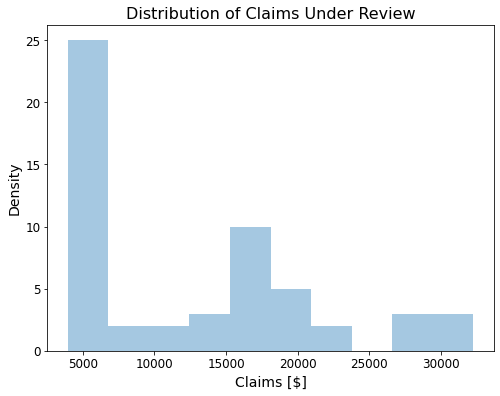

In [7]:
# Estos son casos etiquetados como en revisión 
plt.figure(figsize=(8,6))
# Crear la densidad
sns.distplot(x, bins=10, kde=False)
plt.title('Distribution of Claims Under Review', fontsize=16)
plt.xlabel('Claims [$]', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

Esta es una distribución realmente extraña. Parece que hay tres conjuntos de picos para los montos de las reclamaciones. Intentemos ver algunos diagramas de dispersión en 2D de `claims` frente a `income` e `income` frente a `age` para la población de muestra, para obtener más información sobre lo que está sucediendo:

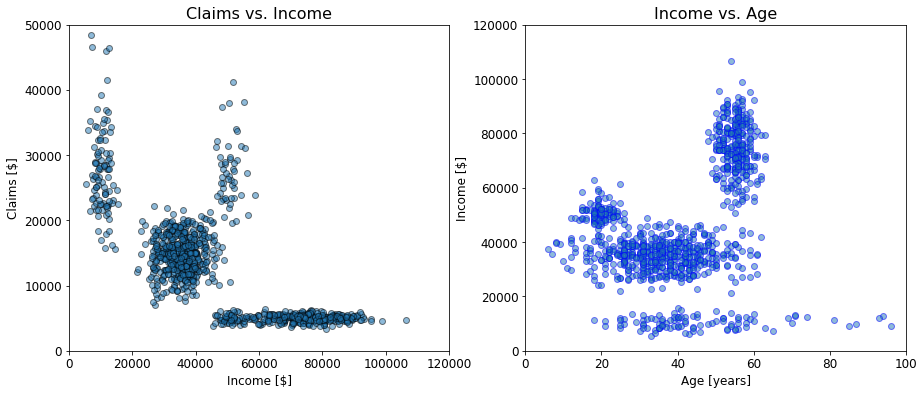

In [8]:
# Claims vs. Income
plt.figure(figsize=(15,6))
plt.subplot(121)
# Hacemos un scatter plot
plt.scatter(df['income'], df['claims'], edgecolor='k', alpha=0.5)
plt.ylim(0, 50000)
plt.yticks(fontsize=12)
plt.ylabel('Claims [$]', fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.title('Claims vs. Income', fontsize=16)

# Income vs Age
plt.subplot(122)
plt.scatter(df['age'], df['income'], edgecolor='b', alpha=0.5)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age', fontsize=16)
plt.show()

También podemos estratificar nuestros datos por género antes de realizar las visualizaciones anteriores:

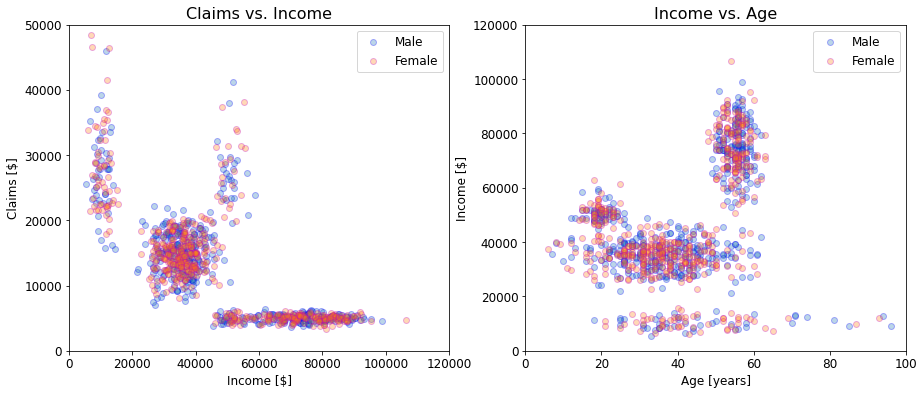

In [9]:
# Extraemos algunas columnas de interes
df_gender = df_data[['case_id', 'income', 'age', 'claims', 'sex']]
# Filtramos por genero
df_male = df_gender[df_gender['sex'] == 'M']
df_female = df_gender[df_gender['sex'] == 'F']
plt.figure(figsize=(15,6))
# Claims vs. Income - con base a genero
plt.subplot(121)
plt.scatter(df_male['income'], df_male['claims'], edgecolor='b', alpha=0.3, label='Male')
plt.scatter(df_female['income'], df_female['claims'], edgecolor='m', alpha=0.3, label='Female')
plt.legend(loc='best', fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 50000)
plt.ylabel('Claims [$]', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Claims vs. Income', fontsize=16)

# Income vs. Age - según genero
plt.subplot(122)
plt.scatter(df_male['age'],df_male['income'], edgecolor='b', alpha=0.3, label='Male')
plt.scatter(df_female['age'],df_female['income'], edgecolor='m', alpha=0.3, label='Female')
plt.legend(loc='best', fontsize=12)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age', fontsize=16)
plt.show()

### Ejercicio 1: (5 min)

¿Qué patrones observa en los gráficos de arriba? ¿Por qué crees que esto podría estar sucediendo?

**Respuesta.** 
No parece haber grandes diferencias en las distribuciones basadas en el género; sin embargo, las graficas muestran algunos grupos claros. Por ejemplo, hay un grupo gigante de reclamos alrededor del rango de ingresos de 30,000-40,000 en la tabla de reclamos versus ingresos, lo que podría deberse al hecho de que el ingreso medio es de aproximadamente 30,000-40,000. También hay una franja de reclamaciones entre 50.000- 100,000 en la tabla de reclamaciones frente a ingresos, que valen 5.000 aproximadamente. No está claro exactamente cuáles son estos reclamos, pero podrían ser cosas cotidianas con las que las personas más pudientes pueden lidiar (por ejemplo, reclamos por accidentes automovilísticos). También hay una franja de reclamos por al menos 20,000 entre las personas que ganan solo $ 10,000, lo cual es inusual y bien puede consistir en reclamos fraudulentos.

En el gráfico de ingresos versus edad, hay una franja de personas que ganan $10,000 en todas las edades (salario mínimo), un gran grupo de personas que ganan entre 30,000-40,000 en todas las edades (salario medio) y un muchas personas de ingresos más altos (60,000-100,0000) justo antes de los 60 años. La edad de 59 1/2 es cuando las personas en los EE.UU. pueden comenzar a sacar ahorros de sus cuentas de jubilación, por lo que esto puede tener algo que ver con este patrón.

### Pregunta: (5 min)

¿Cómo haría para crear un algoritmo que encuentre los grupos que hemos determinado a través del "ojo" en las figuras de arriba? Discutir con un compañero.

## $k$-means clustering (25 min) 
En nuestras visualizaciones anteriores, parece que existen distintas poblaciones de individuos en función de las relaciones entre los reclamos y los ingresos, y los ingresos y la edad. Sin embargo, solo hemos logrado investigar dos relaciones de esta manera, y en conjuntos de datos más grandes con muchas características, hacerlo manualmente en todas las variables puede llevar mucho tiempo. Afortunadamente, los **modelos de agrupamiento** nos permiten resumir y detectar relaciones potencialmente interesantes con bastante rapidez.

Hay muchas variaciones de agrupación en clústeres, pero la más común, y la que veremos, se llama **$k$-means clustering**. Este algoritmo separa el conjunto de datos dado en $k$ grupos que minimizan la suma de los cuadrados de distancias entre cada par de puntos en el grupo. El científico de datos debe preseleccionar el valor de $k$, que puede requerir un análisis previo para determinarlo.

El método tiene 3 pasos amplios, que se pueden resumir de la siguiente manera:

1. Inicialización. Para comenzar, uno debe seleccionar $k$ puntos (no necesariamente ninguno de los puntos de datos, solo puntos en el mismo espacio dimensional) como los centroides "iniciales".
2. Asignación. Cada punto de datos se asigna al grupo correspondiente al centroide más cercano a sí mismo (generalmente basado en la distancia euclidiana estándar).
3. Actualización. Una vez que se han asignado todos los puntos de datos a sus respectivos grupos, se calcula un nuevo centroide para cada grupo tomando la media de todos los puntos en ese grupo.

Luego, se repiten los pasos 2 y 3 hasta que los grupos ya no cambien.

### Ejercicio 2: (5 min)

$k$-means significa que la agrupación se basa en minimizar la distancia euclidiana entre los puntos de datos. ¿Qué tipo de problemas podría plantear esto en términos de los resultados que obtenemos? ¿Cómo podemos solucionar esto?


**Respuesta.** Existe un problema de escala que podría ocurrir. Si algunas variables tienen naturalmente valores muy pequeños mientras que otras tienen valores muy grandes, entonces las características no se ponderan de manera uniforme en el cálculo de la distancia euclidiana. Para solucionar este problema, necesitaríamos escalar cada variable de manera apropiada por una medida de su tamaño; por ejemplo, podríamos dividir todo por la mediana de dicha variable.

Hay muchas formas de escalar, o **normalizar**, variables, una de las cuales hemos mencionado anteriormente. La mejor opción de normalización depende de los detalles particulares del conjunto de datos en cuestión.

De manera similar, la distancia euclidiana es la métrica más utilizada para calcular los clústeres, ya que es bastante fácil de calcular y funciona bien en la mayoría de los conjuntos de datos, pero no es la única. Los científicos de datos a veces usan variaciones en la métrica de distancia según el conjunto de datos que están investigando. Por lo tanto, es un parámetro que debe considerarse y explorarse durante la etapa de EDA para determinar qué es lo mejor a seguir.

### Ejercicio 3: (10 min)

Escribe una función que normalice `age`, `income` y `claims` de acuerdo con los valores mínimos y máximos de cada variable. Por ejemplo, si estamos hablando de `age`, entonces un valor normalizado para una edad $A$ se calcularía como $ \displaystyle\frac{X - min(age)}{max(age)-min(age)}$ (Esto se conoce como el método de escalado mínimo-máximo).

**Respuesta.**

In [ ]:
df.columns

Index(['case_id', 'income', 'age', 'claims'], dtype='object')

In [ ]:
def normalize(df):
    result = df.copy()
    
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)
        
    return result

In [ ]:
df

,case_id,income,age,claims
0,59982,35750.95,42,9518.95
1,87249,24078.27,19,19354.23
2,50406,39241.52,37,13056.04
3,59391,33248.31,26,19238.37
4,96622,38649.96,54,14427.42
...,...,...,...,...
995,96947,11353.88,81,15781.10
996,87668,8799.08,37,37004.41
997,39658,13143.52,35,33580.79
998,77914,9473.25,36,27975.41


In [ ]:
df_norm = normalize(df[['age', 'income', 'claims']])
df_norm

,age,income,claims
0,0.400000,0.301264,0.137252
1,0.144444,0.185900,0.355004
2,0.344444,0.335762,0.215563
3,0.222222,0.276530,0.352439
4,0.533333,0.329915,0.245925
...,...,...,...
995,0.833333,0.060143,0.275895
996,0.344444,0.034893,0.745777
997,0.322222,0.077830,0.669978
998,0.333333,0.041556,0.545876


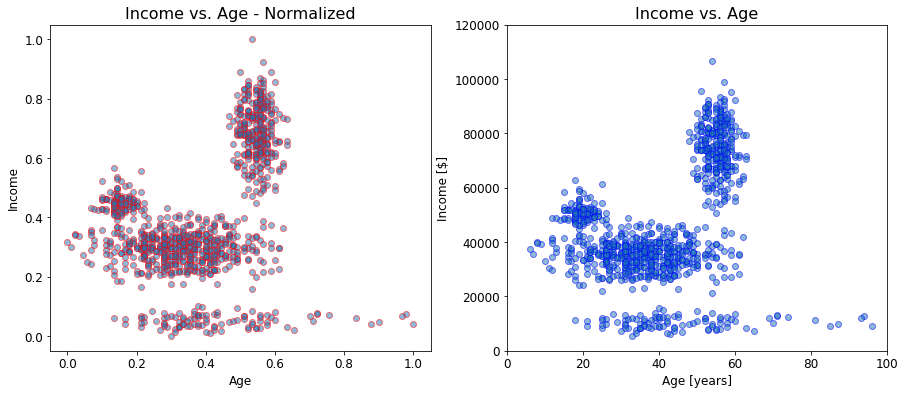

In [ ]:
plt.figure(figsize=(15,6))

# Claims vs. Income - Normalizados
plt.subplot(121)
plt.scatter(df_norm['age'], df_norm['income'], edgecolor='r', alpha=0.5)
#plt.xlim(-0.05, 1.05)
plt.xlabel('Age', fontsize=12)
plt.xticks(fontsize=12)
#plt.ylim(-0.05, 1.05)
plt.ylabel('Income', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age - Normalized', fontsize=16)


# Income vs Age
plt.subplot(122)
plt.scatter(df['age'], df['income'], edgecolor='b', alpha=0.5)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age', fontsize=16)
plt.show()

Los métodos que se muestran arriba transformarán los datos de tal manera que la magnitud de todas las características sea aproximadamente similar. Sin embargo, puede haber un método de escalado diferente que permita que el clustering de $k$-means funcione mejor. La mejor elección de método de escala depende de los datos específicos proporcionados.

### Implementacion del $k$-means usando `sklearn` (5 min)

In [ ]:
df_norm.head()

,age,income,claims
0,0.400000,0.301264,0.137252
1,0.144444,0.185900,0.355004
2,0.344444,0.335762,0.215563
3,0.222222,0.276530,0.352439
4,0.533333,0.329915,0.245925


In [ ]:
k = 4 # Definir los grupos 
kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(df_norm)

labels = kmeans.predict(df_norm)
centroids = kmeans.cluster_centers_
centroids

array([[0.39007937, 0.29014617, 0.24985894],
       [0.54697139, 0.69022897, 0.03759993],
       [0.43997709, 0.05063728, 0.54749975],
       [0.18109453, 0.36139374, 0.2670851 ]])

In [ ]:
labels[0:5]

array([0, 3, 0, 3, 0], dtype=int32)

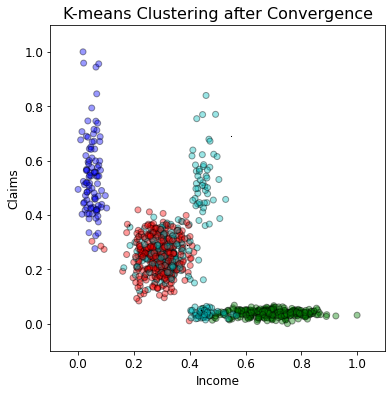

In [ ]:
# Graficar la data 
plt.figure(figsize=(6, 6))
color_map = {1:'r', 2:'g', 3:'b' , 4:'c', 5:'y', 6:'w'}
colors = [color_map[x+1] for x in labels]

plt.scatter(df_norm['income'], df_norm['claims'], color=colors, alpha=0.4, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, marker='*', edgecolor='k')
plt.xlim(-0.1, 1.1)
plt.xlabel('Income', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(-0.1, 1.1)
plt.ylabel('Claims', fontsize=12)
plt.yticks(fontsize=12)
plt.title('K-means Clustering after Convergence', fontsize=16)
plt.show()

## Seleccionar el valor optimo de $k$ (25 min)

Aunque el análisis visual sugiere que $ k = 4 $ es el valor óptimo, es una buena práctica verificar esto cuantitativamente en lugar de simplemente mirarlo a simple vista. Esto es especialmente importante cuando se agrupan datos que no se pueden visualizar fácilmente, un hecho común con datos multidimensionales complejos.

### Ejercicio 5: (5 min)

¿Cómo podría construir un método cuantitativo para determinar los $ k $ óptimos?

**Respuesta.** 
Dado que el algoritmo $k$-means minimiza la suma de cuadrados dentro de cada grupo, esta es la función objetivo con la que debemos comparar todos los valores posibles de $k$. Podemos construir un gráfico de líneas que muestre cómo cambia esta suma de cuadrados a medida que cambia $k$, luego seleccionar el valor de $k$ con el valor más bajo.

Sin embargo, este método no funciona del todo; imagine el caso en el que tiene el mismo número de clústeres que puntos de datos. Entonces, la suma de cuadrados es obviamente cero, ¡pero difícilmente se podría argumentar que tal agrupación es una buena idea! Por lo tanto, es prudente agregar un término de penalización (similar a cómo la métrica AIC contiene un término de penalización) correspondiente al valor de $k$. Esto permitirá que nuestro gráfico toque fondo mucho antes de que $k$ se vuelva demasiado grande, ya que el beneficio incremental de agregar solo un grupo más disminuye a medida que aumenta $k$, mientras que aumenta la penalización incremental.

El método descrito en el ejercicio 5 es una forma de **regularización**; sin embargo, todavía no estamos listos para llegar allí. Por ahora, seremos poco científicos acerca de esto, en lugar de eso, omitiremos el término de penalización y buscaremos el valor de $k$ en el gráfico lineal más allá del cual el cambio en la suma de cuadrados es efectivamente insignificante. A esto se le llama **método del codo**.

### Ejercicio 7: (10 min)

Implemente el esquema del método del codo que describimos anteriormente. ¿Parece correcta nuestra suposición inicial de $ k $?

In [ ]:
sum_sq_d = []
K = range(1,11)
print(K)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm[['income', 'claims']])
    sum_sq_d.append(km.inertia_)
print(sum_sq_d)   

range(1, 11)
[79.04209525971277, 27.4032658427282, 15.488468116200442, 11.136946516742086, 7.6975187471232465, 6.383110311575335, 5.109031921789001, 4.13719939381774, 3.5690425780394985, 3.2172085815007208]


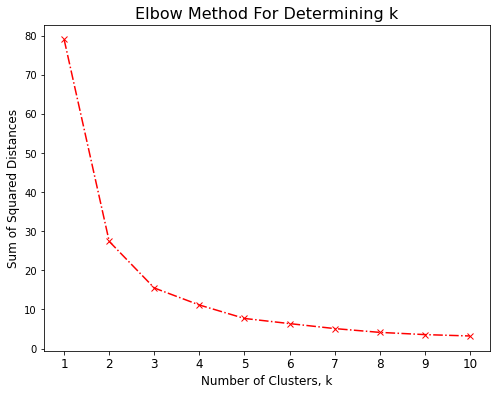

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(K, sum_sq_d, 'rx-.')
plt.xlabel('Number of Clusters, k', fontsize=12)
plt.xticks(range(1,11), fontsize=12)
plt.ylabel('Sum of Squared Distances', fontsize=12)
plt.xticks(fontsize=12)
plt.title('Elbow Method For Determining k', fontsize=16)
plt.show()

A partir del gráfico, parecería que el valor de agregar más grupos realmente comienza a disminuir alrededor de $k = 3$. $k = 4$ está muy cerca de eso, por lo que podemos decir que nuestra suposición inicial fue acertada (es bastante común que nuestra suposición visual y la salida del método anterior sean ligeramente diferentes). Recuerde, este método funciona en múltiples dimensiones, por lo que si bien la agrupación puede ser obvia en una dimensión, puede desaparecer cuando se combina con más variables.

### Ejercicio 8 (5 min):

Dados los cuatro grupos de reclamos que identificamos en función del cuadro de ingresos frente a reclamos, y teniendo en cuenta la información del cuadro de ingresos frente a la edad, haga una sugerencia sobre lo que el departamento debería hacer con cada grupo.

**Respuesta.** 
Tenemos cuatro grupos. 

1. El primero son aquellos con ingresos altos y reclamos bajos, que probablemente sean reclamos ordinarios hechos por familias acomodadas. Es muy probable que estos no sean fraudulentos y que la empresa los acepte. 

2. El segundo son los ingresos moderados con valores de reclamación moderados. Estos son bastante abundantes y podrían ser elementos cotidianos como reclamos de automóviles. Lo más probable es que debamos aceptarlos. 

3. El tercero son los ingresos moderados y las altas reclamaciones. Esto podría ser plausible si es algo que las personas de ingresos medios necesitan pero que no siempre pueden pagar, como ciertas declaraciones de propiedades saludables. Así que probablemente deberíamos investigar esto más a fondo. 

4. La última categoría es la de ingresos bajos pero reclamaciones muy elevadas. Estos claramente no son acsequibles y, con la excepción de algo como las declaraciones de propiedades saludables, bien podrían ser intentos de obtener efectivo gratis. Lo más probable es que los rechacemos.

### Ejercicio 9 (5 min):
Dado lo que ha aprendido sobre el algoritmo $k  -means, ¿cuáles son algunos posibles inconvenientes cuando se aplica a conjuntos de datos?

**Respuesta.** 

Hay algunas deficiencias potenciales (estos son ejemplos, obviamente hay otras posibles respuestas):

1. El algoritmo $k$-means da más peso a los clústeres más grandes, ya que intenta minimizar la variación intra-clúster, por lo que en los casos en los que los clústeres no tienen naturalmente el mismo tamaño, esto podría resultar en resultados sesgados.
2. No necesariamente converge de forma uniforme o rápida, por lo que la elección de los puntos iniciales es sumamente importante. Este grado de dependencia no es necesariamente el ideal.
3. Los valores atípicos pueden influir en gran medida en los datos y las medias del grupo, a menos que se cumpla una alternativa

## Conclusiones (3 min)

En este caso, dividimos con éxito el conjunto de datos en 4 grupos separados y validamos nuestra intuición basada en la agrupación de $k$means. Aprendimos que hay muchos supuestos incorporados en la agrupación de $k$-means (es decir, la elección de la métrica de distancia, la normalización y $k$) y que esto no se puede automatizar fácilmente, ya que estas opciones dependen del conjunto de datos particular en mano. Una vez que se han identificado los grupos individuales, la compañía de seguros ahora puede determinar qué reclamos investigar más a fondo o considerar de inmediato como fraudulentos en función de algunos criterios adicionales.

## Para llevar (5 min)

En este caso, presentamos los conceptos de técnicas de **aprendizaje no supervisado** y **agrupación**. En particular, discutimos el algoritmo **$k$-means** y su funcionamiento interno. Hicimos esto por:

1. Visualización de un conjunto de datos para generar posibles agrupaciones en nuestros datos
2. Presentamos el concepto de $k$-means y cómo funciona el algoritmo
3. Alterar los datos para que se ajusten a los errores del algoritmo
4. Validamos nuestra hipótesis inicial de los clusters en los datos mediante la implementación del algoritmo

La agrupación es una poderosa herramienta de aprendizaje no supervisada para investigar datos no etiquetados, particularmente para determinar patrones que no se conocían o entendían previamente. En el caso de grandes conjuntos de datos, se pueden identificar relaciones muy complejas entre grupos de puntos de datos individuales que posiblemente no se podrían hacer a través del ojo humano.

Si bien esta es una buena técnica para datos de baja dimensión, $k$-means es susceptible a un rendimiento deficiente en dimensiones más altas, como muchos algoritmos de aprendizaje automático. En dimensiones más altas, primero se realizan técnicas más avanzadas, como **t-SNE**, para reducir el número de dimensiones antes de agrupar. Finalmente, $k$-means es solo uno de los muchos algoritmos de agrupamiento. Los desarrollos modernos incluyen los algoritmos **DBSCAN** y **OPTICS**.

## Apendice: manual del $k$-means implementacion & monitorero (20 min)

Aquí mostramos cómo funciona el algoritmo real de $k$-means, desde la inicialización de los clústeres, hasta los pasos de actualización y el resultado final:

Initial Centroids (age, income) are: {1: [-1.0, 0.5], 2: [0.5, -1.0], 3: [0.25, -0.5], 4: [-0.5, -1.0]}
        age    income    claims  ...  distance_from_4  closest  color
0  0.400000  0.301264  0.137252  ...             1.39        3      b
1  0.144444  0.185900  0.355004  ...             1.52        3      b
2  0.344444  0.335762  0.215563  ...             1.48        3      b
3  0.222222  0.276530  0.352439  ...             1.56        3      b
4  0.533333  0.329915  0.245925  ...             1.50        3      b

[5 rows x 9 columns]


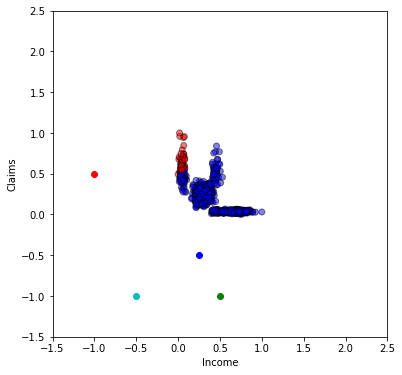

In [ ]:
# Inicializando el metodo:

# asignar el numero de clusters a utilizar
k = 4

# Inicializar la media de los clusters o centroides
centroids = {i+1: [np.random.choice([-1,-0.5,0.25,0.5]), np.random.choice([-1,-0.5,0.25,0.5])]
    for i in range(k)
}
print(f"Initial Centroids (age, income) are: {centroids}")
color_map = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}
# funcion de asignacion de cluster mas cercano a cada punto 
def assignment(df, centroids):
    tmp = df.copy()
    for i in centroids.keys():
        tmp[f"distance_from_{i}"] = (np.sqrt(
            (df['income'] - centroids[i][0])**2 + (tmp['claims'] - centroids[i][1]) ** 2)
        ).round(2)
    centroid_distance_cols = [f"distance_from_{i}" for i in centroids.keys()]
    tmp['closest'] = tmp.loc[:, centroid_distance_cols].idxmin(axis=1)
    tmp['closest'] = tmp['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    tmp['color'] = tmp['closest'].map(lambda x: color_map[x])
    return tmp
# Aplicar la funcion
df_centroids = assignment(df_norm, centroids)
print(df_centroids.head())
plt.figure(figsize=(6, 6))
plt.scatter(df_centroids['income'], df_centroids['claims'], color=df_centroids['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i])    
plt.xlim(-1.5, 2.5)
plt.xlabel('Income')
plt.ylim(-1.5, 2.5)
plt.ylabel('Claims')
plt.show()

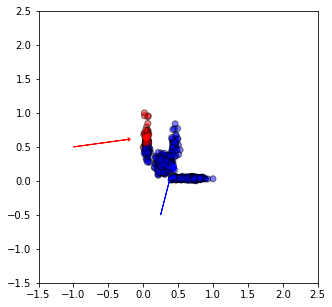

In [ ]:
'''
Etapa de actualizacion: Aqui actualizamos los centorides
Todos los puntos son asignados al k esimo cluster
'''
# Copiar los valores previos y crear una neuva entrada 
import copy
old_centroids = copy.deepcopy(centroids)
# Funcion para hacer el update de los k cluster
def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df_centroids[df_centroids['closest'] == i]['income'])
        centroids[i][1] = np.mean(df_centroids[df_centroids['closest'] == i]['claims'])
    return k
centroids = update(centroids)
plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.scatter(df_centroids['income'], df_centroids['claims'], color=df_centroids['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i])
    
plt.xlim(-1.5, 2.5)
plt.ylim(-1.5, 2.5)
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    ax.arrow(old_x, old_y, dx, dy, head_width=0.05, head_length=0.03, fc=color_map[i], ec=color_map[i])
    
plt.show()

Tenga en cuenta que los centroides pueden desaparecer porque se inicializan vacíos. Esto es algo importante que debe recordar. Si tiene una idea aproximada de dónde están los centroides, inicialice el algoritmo. No hay sustituto para el conocimiento previo. Afortunadamente para nosotros, `sklearn` maneja casos degenerados como este y mantiene constante $k$.

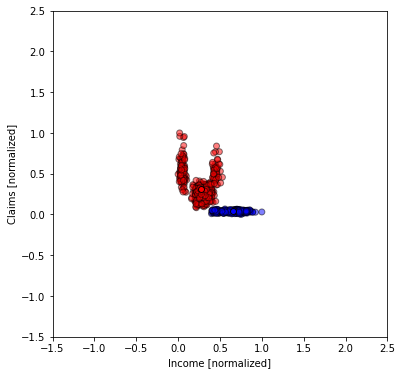

In [ ]:
# Proceso iterativo: Reasignar los nuevos pesos
df_centroids = assignment(df_centroids, centroids)
# Continuar haciendo esto hasta que se tengan nuevas asignaciones
while True:
    closest_centroids = df_centroids['closest'].copy(deep=True)
    centroids = update(centroids)
    df_centroids = assignment(df_centroids, centroids)    
    if closest_centroids.equals(df_centroids['closest']):
        break
plt.figure(figsize=(6, 6))
plt.scatter(df_centroids['income'], df_centroids['claims'], color=df_centroids['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=color_map[i], edgecolor='k')
    
plt.xlim(-1.5, 2.5)
plt.xlabel('Income [normalized]')
plt.ylim(-1.5, 2.5)
plt.ylabel('Claims [normalized]')
plt.show()